In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft
from scipy.io import wavfile
from scipy import signal
from glob import glob
import re
import pandas as pd
import gc
import csv
import webrtcvad

import tensorflow as tf
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import librosa
import librosa.display

In [2]:
classes = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence', 'unknown']
train_dir = 'data/train/train/audio/'
test_dir = 'data/test/audio/'

In [3]:
filename1 = '/no/0a9f9af7_nohash_0.wav'
filename2 = '/on/00b01445_nohash_0.wav'
filename =  '/yes/0a7c2a8d_nohash_0.wav'
sr1, sam1 = wavfile.read(str(train_dir) + filename1)
sr2, sam2 = wavfile.read(str(train_dir) + filename2)
sr3, sam3 = wavfile.read(str(train_dir) + filename)

In [4]:
import IPython.display as ipd
ipd.Audio(sam1, rate=sr1)

In [5]:
ipd.Audio(sam2, rate=sr2)

In [6]:
sam11 = sam1.astype(np.float32)

In [7]:
y_8k = librosa.resample(sam11, sr1, 8000)
ipd.Audio(y_8k, rate=8000)

In [8]:
normed_wav = sam1 / max(np.abs(sam1))
ipd.Audio(normed_wav, rate=sr1)

In [9]:
Bit = 8
max_value = 2 ** (Bit-1)

quantized_8_wav = normed_wav * max_value
quantized_8_wav = np.round(quantized_8_wav).astype(int)
quantized_8_wav = np.clip(quantized_8_wav, -max_value, max_value-1)
ipd.Audio(quantized_8_wav, rate=sr1)

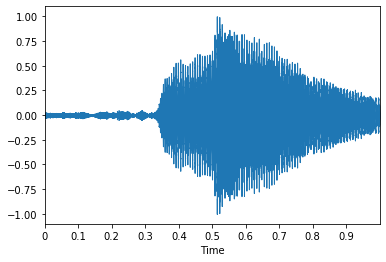

In [10]:
librosa.display.waveplot(normed_wav, sr=sr1)

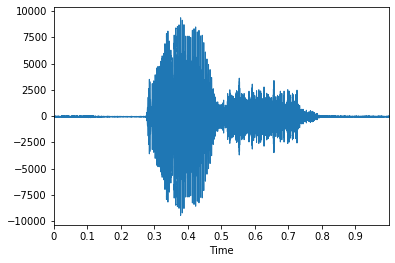

In [11]:
librosa.display.waveplot(sam3.astype(float), sr=sr3)

In [12]:
sam3

array([ 14,  -7, -14, ...,  19,  20,  27], dtype=int16)

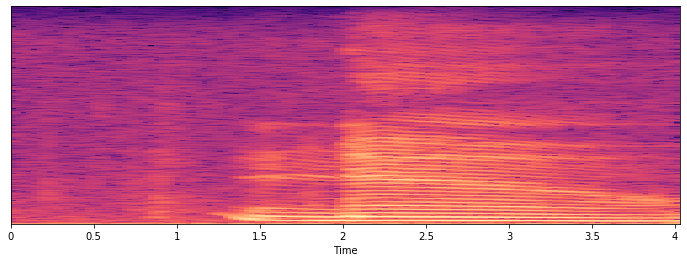

In [14]:
S = librosa.core.stft(normed_wav, n_fft=1024, hop_length=128, win_length=1024)
D = np.abs(S)**2
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sr1, x_axis='time')

In [32]:
!pip install webrtcvad

  Created wheel for webrtcvad: filename=webrtcvad-2.0.10-cp36-cp36m-win_amd64.whl size=19814 sha256=13ccacdeb491116eea8ca90d09f2ca842f8ca8e1113b5a7198b4e36789326c7e
  Stored in directory: c:\users\gyu\appdata\local\pip\cache\wheels\ba\22\1c\d4e9707bbb27d469c384efc4263d8c7125219c1f088937289c
Successfully built webrtcvad


In [33]:
D.shape

(513, 126)

In [25]:
mel_basis = librosa.filters.mel(sr1, 1024, n_mels=40)
mel_S = np.dot(mel_basis, D)
mel_S.shape

(40, 126)

In [17]:
import webrtcvad

vad = webrtcvad.Vad()
vad.set_mode(3)

class Frame(object):
    def __init__(self, bytes, timestamp, duration):
        self.bytes = bytes
        self.timestamp = timestamp
        self.duration = duration

def frame_generator(frame_duration_ms, audio, sample_rate):
    frames = []
    n = int(sample_rate * (frame_duration_ms / 1000.0) * 2)
    print(n)
    offset = 0
    timestamp = 0.0
    duration = (float(n) / sample_rate) / 2.0
    print(duration)
    while offset + n < len(audio):
        frames.append(Frame(audio[offset:offset + n], timestamp, duration))
        timestamp += duration
        offset += n
    return frames

def auto_vad(vad, samples, sample_rate, frame_duration_ms = 10):
    not_speech = []
    frames = frame_generator(frame_duration_ms, samples, sample_rate)
    n_frame = len(frames)
    for idx, frame in enumerate(frames):
        if not vad.is_speech(frame.bytes, sample_rate):
            not_speech.append(idx)
    prior = 0
    cutted_samples = []
    for i in not_speech:
        print(i)
        if i - prior > 2:
            start = int((float(prior) / n_frame) * sample_rate)
            end = int((float(i) / n_frame) * sample_rate)
            print(start, end)
            if len(cutted_samples) == 0:
                cutted_samples = samples[start:end]
            else:
                cutted_samples = np.append(cutted_samples, samples[start:end])
        prior = i
    return cutted_samples

cutted_samples = auto_vad(vad, normed_wav, sr1, 10)
ipd.Audio(cutted_samples, rate=sr1)

320
0.01
0


ValueError: zero-size array to reduction operation maximum which has no identity

In [44]:
resampled = signal.resample(sam1, int(8000/sr1 * sam1.shape[0]))

In [19]:
import struct
raw_samples = struct.pack("%dh" % len(sam1), *sam1)
window_duration = 0.03 # duration in seconds

samples_per_window = int(window_duration * sr1 + 0.5)

bytes_per_sample = 2

In [20]:
segments = []

for start in np.arange(0, len(sam1), samples_per_window):
    stop = min(start + samples_per_window, len(sam1))
    
    is_speech = vad.is_speech(raw_samples[start * bytes_per_sample: stop * bytes_per_sample], 
                              sample_rate = sr1)

    segments.append(dict(
       start = start,
       stop = stop,
       is_speech = is_speech))

In [21]:
segments

[{'start': 0, 'stop': 480, 'is_speech': True},
 {'start': 480, 'stop': 960, 'is_speech': True},
 {'start': 960, 'stop': 1440, 'is_speech': True},
 {'start': 1440, 'stop': 1920, 'is_speech': True},
 {'start': 1920, 'stop': 2400, 'is_speech': False},
 {'start': 2400, 'stop': 2880, 'is_speech': False},
 {'start': 2880, 'stop': 3360, 'is_speech': False},
 {'start': 3360, 'stop': 3840, 'is_speech': False},
 {'start': 3840, 'stop': 4320, 'is_speech': False},
 {'start': 4320, 'stop': 4800, 'is_speech': False},
 {'start': 4800, 'stop': 5280, 'is_speech': False},
 {'start': 5280, 'stop': 5760, 'is_speech': True},
 {'start': 5760, 'stop': 6240, 'is_speech': True},
 {'start': 6240, 'stop': 6720, 'is_speech': True},
 {'start': 6720, 'stop': 7200, 'is_speech': True},
 {'start': 7200, 'stop': 7680, 'is_speech': True},
 {'start': 7680, 'stop': 8160, 'is_speech': True},
 {'start': 8160, 'stop': 8640, 'is_speech': True},
 {'start': 8640, 'stop': 9120, 'is_speech': True},
 {'start': 9120, 'stop': 9600, 

In [23]:
speech_samples = np.concatenate([ sam1[segment['start']:segment['stop']] for segment in segments if segment['is_speech']])

ipd.Audio(speech_samples, rate=sr1)

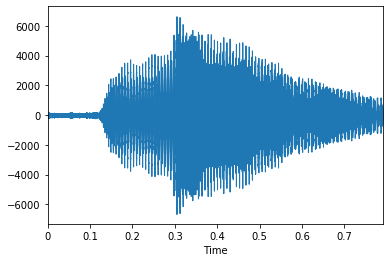

In [25]:
librosa.display.waveplot(speech_samples.astype(float), sr=sr1)

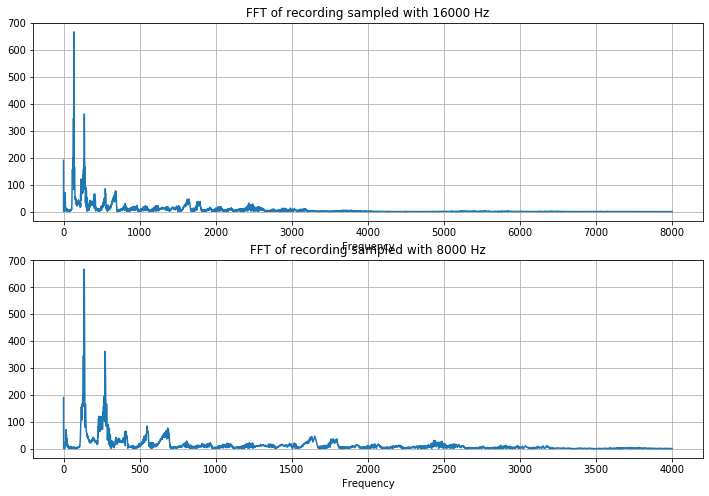

In [51]:
plt.figure(figsize=(12, 8))

plt.subplot(211)
xf, vals = custom_fft(sam1, sr1)
plt.title('FFT of recording sampled with ' + str(sr1) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()

plt.subplot(212)
xf, vals = custom_fft(resampled, 8000)
plt.title('FFT of recording sampled with ' + str(8000) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

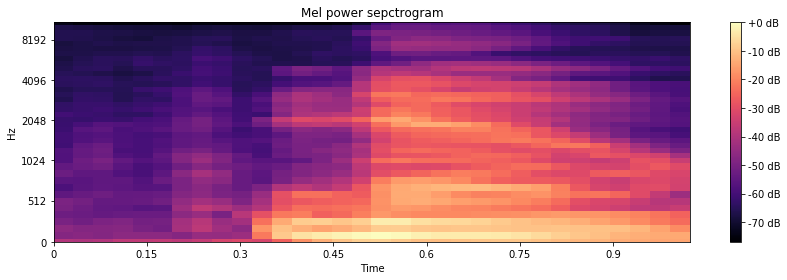

In [29]:
S = librosa.feature.melspectrogram(sam11, sr=sr1, n_mels = 40)
log_S = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sr1, x_axis='time', y_axis='mel')
plt.title('Mel power sepctrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

In [15]:
def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])
    return xf, vals

def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

Text(0.5, 0, 'Seconds')

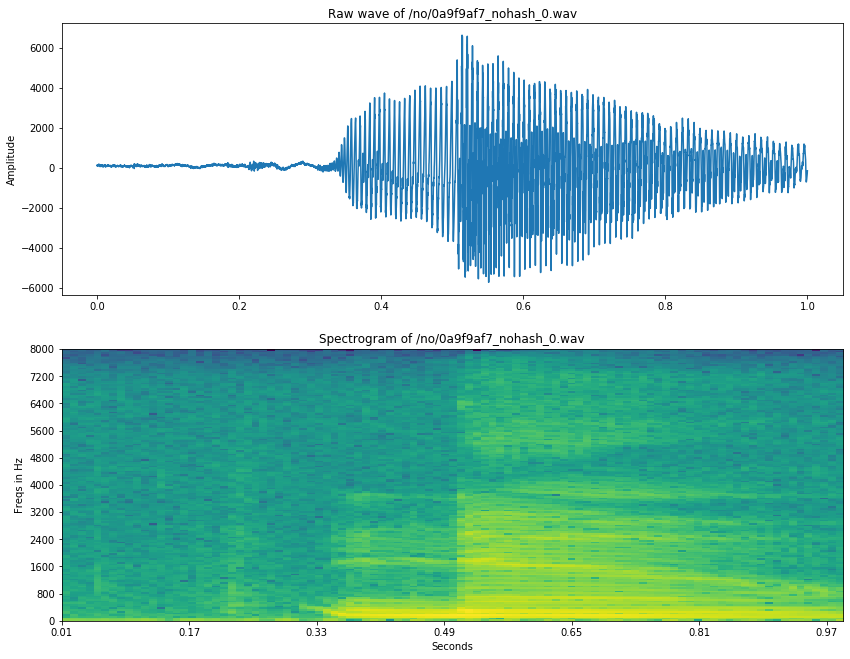

In [10]:
freqs, times, spectrogram = log_specgram(sam1, sr1)


fig = plt.figure(figsize=(14, 11))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename1)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sr1/len(sam1), sr1), sam1)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower',
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename1)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [11]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

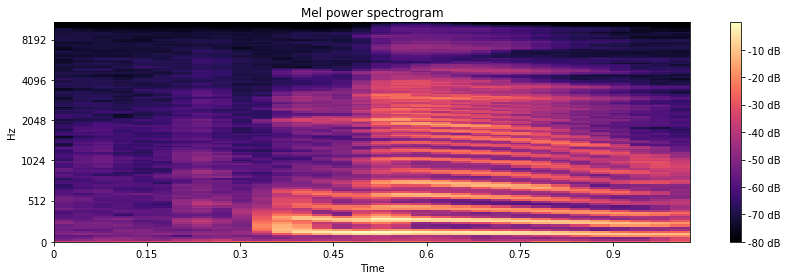

In [13]:
S = librosa.feature.melspectrogram(sam1.astype(float), sr=sr1, n_mels=128)
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sr1, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

In [28]:
def split_arr(arr):
    return np.split(arr, np.arange(16000, len(arr), 16000))

def create_silence():
    
    for file in os.listdir('data/train/train/audio/_background_noise_/'):
        if 'wav' in file:
            sig, rate = librosa.load('data/train/train/audio/_background_noise_/' + file, sr = 16000)        
            sig_arr = split_arr(sig)
            if not os.path.exists(train_dir+'silence/'):
                os.makedirs(train_dir+'silence/')
            for ind, arr in enumerate(sig_arr):
                filename = 'frag%d' %ind + '_%s' %file # example: frag0_running_tap.wav
                librosa.output.write_wav(train_dir+'silence/'+filename, arr, 16000)

In [12]:
create_silence()

In [24]:
folders = os.listdir(train_dir)
# put folders in same order as in the classes list, used when making sets
all_classes = [x for x in classes[:11]]
for ind, cl in enumerate(folders):
    if cl not in classes:
        all_classes.append(cl)
print(all_classes)

['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence', 'bed', 'bird', 'cat', 'dog', 'eight', 'five', 'four', 'happy', 'house', 'marvin', 'nine', 'one', 'seven', 'sheila', 'six', 'three', 'tree', 'two', 'wow', 'zero', '_background_noise_']


In [29]:
with open('./data/train/train/validation_list.txt') as val_list:
    validation_list = [row[0] for row in csv.reader(val_list)]
assert len(validation_list) == 6798, 'file not loaded'


with open('./data/train/train/testing_list.txt') as test_list:
    testing_list = [row[0] for row in csv.reader(test_list)]
assert len(testing_list) == 6835, 'file not loaded'

validation_list.extend(testing_list)

#add silence files to validation_list
for i, file in enumerate(os.listdir(train_dir + 'silence/')):
    if i%10==0:
        validation_list.append('silence/'+file)
    if i%10==5:
        testing_list.append('silence/'+file)

training_list = []
all_files_list = []
class_counts = {}

for folder in folders:
    files = os.listdir(train_dir + folder)
    for i, f in enumerate(files):
        all_files_list.append(folder + '/' + f)
        path = folder + '/' + f
        if path not in validation_list:
            training_list.append(folder + '/' + f)        
        class_counts[folder] = i

#remove filenames from validation_list that don't exist anymore (due to eda)
validation_list = list(set(validation_list).intersection(all_files_list))
testing_list = list(set(testing_list).intersection(all_files_list))

NameError: name 'folders' is not defined

In [26]:
assert len(validation_list)+len(training_list)==len(all_files_list), 'error'
print('size training set: ',len(training_list), 'size validation set: ', len(validation_list))

NameError: name 'validation_list' is not defined

In [19]:
def make_spec(file, file_dir = train_dir, flip = False, ps = False, st = 4):
    sig, rate = librosa.load(file_dir + file, sr = 16000)
    if len(sig) < 16000: 
        sig = np.pad(sig, (0,16000-len(sig)), 'linear_ramp')
    if ps:
        sig = librosa.effects.pitch_shift(sig, rate, st)
    D = librosa.amplitude_to_db(librosa.stft(sig[:16000], n_fft = 512, 
                                             hop_length = 128, 
                                             center = False), ref = np.max)
    S = librosa.feature.melspectrogram(S=D, n_mels = 85).T
    if flip:
        S = np.flipud(S)
    return S.astype(np.float32)


def create_sets(file_list = training_list):
    X_array = np.zeros([len(file_list),122,85])
    Y_array = np.zeros([len(file_list)])    
    for ind, file in enumerate(file_list):
        if ind%2000 == 0:
            print(ind, file)
        try:
            X_array[ind] = make_spec(file)
        except ValueError:
            print(ind, file, ValueError)
        Y_array[ind] = all_classes.index(file.rsplit('/')[0])
        
    return X_array, Y_array

In [20]:
X_train, Y_train_all = create_sets()

MemoryError: 

In [10]:
Y_train = np.where(Y_train_all < 11, Y_train_all, 11)

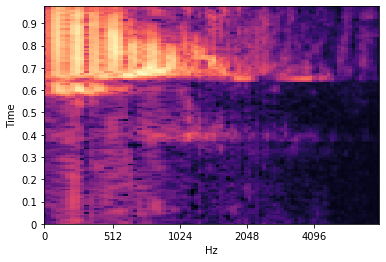

In [11]:
librosa.display.specshow(X_train[6500], 
                         x_axis='mel', 
                         fmax=8000, 
                         y_axis='time', 
                         sr = 16000,
                         hop_length = 128)

In [12]:
np.save('data/X_train.npy', np.expand_dims(X_train, -1)+1.3)
np.save('data/Y_train.npy', Y_train.astype(np.int))
np.save('data/Y_train_all.npy', Y_train_all.astype(np.int))

In [13]:
X_val, Y_val_all = create_sets(file_list = validation_list)

0 seven/d874a786_nohash_2.wav
2000 bird/c50225fa_nohash_0.wav
4000 go/bfbd0e6b_nohash_0.wav
6000 nine/7be5a0f3_nohash_0.wav


(array([  154940.,    18034.,   411645.,   957655., 10309001.,  2858928.,
         2146576.,  2155732.,  2049895.,  2059560.,  2087878.,  2115105.,
         2131921.,  2143091.,  2147211.,  2145472.,  2141145.,  2122308.,
         2093091.,  2052971.,  2001151.,  1937760.,  1861065.,  1777600.,
         1682795.,  1581886.,  1478662.,  1374767.,  1280461.,  1184080.,
         1096084.,  1018682.,   944486.,   879568.,   818266.,   759390.,
          710978.,   661559.,   607011.,   554466.,   498156.,   439133.,
          377712.,   313458.,   252177.,   195596.,   145016.,    98460.,
           61722.,    26124.]),
 array([-2.03061795e+00, -1.99000559e+00, -1.94939323e+00, -1.90878087e+00,
        -1.86816851e+00, -1.82755615e+00, -1.78694379e+00, -1.74633143e+00,
        -1.70571906e+00, -1.66510670e+00, -1.62449434e+00, -1.58388198e+00,
        -1.54326962e+00, -1.50265726e+00, -1.46204490e+00, -1.42143254e+00,
        -1.38082018e+00, -1.34020782e+00, -1.29959546e+00, -1.25898309e+

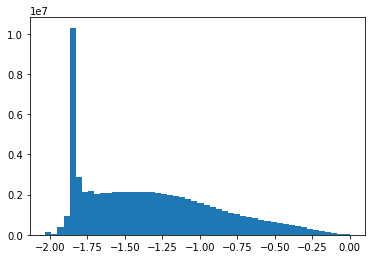

In [14]:
Y_val = np.where(Y_val_all < 11, Y_val_all, 11)
plt.hist(X_val.flatten(), bins = 50)

In [15]:
np.save('data/X_val.npy', np.expand_dims(X_val, -1)+1.3)
np.save('data/Y_val.npy', Y_val.astype(np.int))
np.save('data/Y_val_all.npy', Y_val_all.astype(np.int))

In [35]:
X_val.shape

(6839, 122, 85)

In [9]:
X_train = np.load('data/X_train.npy')
Y_train = np.load('data/Y_train.npy')
Y_train_all = np.load('data/Y_train_all.npy')

In [17]:
X_val = np.load('data/X_val.npy')
Y_val = np.load('data/y_val.npy')
Y_val_all = np.load('data/Y_val_all.npy')

In [12]:
X_train = X_train.reshape((58290, 122, 85,1))
X_val = X_val.reshape((6839, 122, 85,1))

In [16]:
X_train.shape

(58290, 122, 85, 1)

In [ ]:
nclass = 12
inp = Input(shape=X_train.shape[1:])
norm_inp = BatchNormalization()(inp)
img_1 = Convolution2D(8, kernel_size=(3,3), padding = 'valid', activation=activations.relu)(norm_inp)
img_1 = Convolution2D(8, kernel_size=(3,3), padding = 'same',activation=activations.relu)(img_1)
img_1 = MaxPooling2D(pool_size=(2, 2))(img_1)
img_1 = Dropout(rate=0.2)(img_1)
img_1 = Convolution2D(16, kernel_size=(3,3), padding = 'same', activation=activations.relu)(img_1)
img_1 = Convolution2D(16, kernel_size=(3,3), padding = 'same', activation=activations.relu)(img_1)
img_1 = MaxPooling2D(pool_size=(2, 2))(img_1)
img_1 = Dropout(rate=0.2)(img_1)
img_1 = Convolution2D(32, kernel_size=(3,3), padding = 'valid',activation=activations.relu)(img_1)
img_1 = Convolution2D(32, kernel_size=(3,3), padding = 'same', activation=activations.relu)(img_1)
img_1 = MaxPooling2D(pool_size=(2, 2))(img_1)
img_1 = Dropout(rate=0.2)(img_1)
img_1 = Flatten()(img_1)

dense_1 = BatchNormalization()(Dense(128, activation=activations.relu)(img_1))
dense_1 = BatchNormalization()(Dense(128, activation=activations.relu)(dense_1))
dense_1 = Dense(nclass, activation=activations.softmax)(dense_1)

model = models.Model(inputs=inp, outputs=dense_1)
opt = optimizers.Adam()

model.compile(optimizer=opt, loss='categorical_crossentropy',metrics =['accuracy'])
model.summary()

# x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=2017)
model.fit(X_train, to_categorical(Y_train), batch_size=16, validation_data=(X_val, to_categorical(Y_val)), epochs=3, shuffle=True, verbose=2)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 122, 85, 1)]      0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 122, 85, 1)        4         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 120, 83, 8)        80        
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 120, 83, 8)        584       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 60, 41, 8)         0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 60, 41, 8)         0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 60, 41, 16)        1168

In [30]:
model.fit(X_train, to_categorical(Y_train), batch_size=16, validation_data=(X_val, to_categorical(Y_val)), epochs=1, shuffle=True, verbose=2)

NameError: name 'model' is not defined

In [41]:
model.save('data/model.h5')

In [48]:
model.load_weights('data/model.h5')

In [3]:
folders = os.listdir(test_dir)
test_list = []
for folder in folders:
    test_list.append(folder)

In [8]:
def create_testsets(file_list = test_list):
    X_array = np.zeros([len(file_list),122,85])   
    for ind, file in enumerate(file_list):
        if ind%2000 == 0:
            print(ind, file)
        try:
            X_array[ind] = make_spec(file,file_dir =test_dir)
        except ValueError:
            print(ind, file, ValueError)
    return X_array

X_test = create_testsets()

MemoryError: 

In [2]:
def list_wavs_fname(dirpath, ext='wav'):
    print(dirpath)
    fpaths = glob(os.path.join(dirpath, r'*/*' + ext))
    pat = r'.+/(\w+)/\w+\.' + ext + '$'
    labels = []
    for fpath in fpaths:
        r = re.match(pat, fpath)
        if r:
            labels.append(r.group(1))
    pat = r'.+/(\w+\.' + ext + ')$'
    fnames = []
    for fpath in fpaths:
        r = re.match(pat, fpath)
        if r:
            fnames.append(r.group(1))
    return labels, fnames

def pad_audio(samples):
    if len(samples) >= L: return samples
    else: return np.pad(samples, pad_width=(L - len(samples), 0), mode='constant', constant_values=(0, 0))

def chop_audio(samples, L=16000, num=20):
    for i in range(num):
        beg = np.random.randint(0, len(samples) - L)
        yield samples[beg: beg + L]

def label_transform(labels):
    nlabels = []
    for label in labels:
        if label == '_background_noise_':
            nlabels.append('silence')
        else:
            nlabels.append(label)
    return pd.get_dummies(pd.Series(nlabels))

In [9]:
L = 16000
audio_path = 'data/train/train/audio'
train_files = sorted(glob(audio_path + '/*'))

for file in train_files:
    fpaths = glob(os.path.join(dirpath, r'*/*' + "wav"))
    for fpa in fpaths:
        dataset = np.load(fpa
        target= dataset[:,:,-1].reshape(40,40,1)
        cutoff_labels = np.where(target < 0, 0, target)
        feature = dataset[:,:,:14]
# labels, fnames = list_wavs_fname(audio_path)

# new_sample_rate = 8000
# y_train = []
# x_train = []

# for label, fname in zip(labels, fnames):
#     sample_rate, samples = wavfile.read(os.path.join(audio_path, label, fname))
#     samples = pad_audio(samples)
#     if len(samples) > 16000:
#         n_samples = chop_audio(samples)
#     else: n_samples = [samples]
#     for samples in n_samples:
#         resampled = signal.resample(samples, int(new_sample_rate / sample_rate * samples.shape[0]))
#         _, _, specgram = log_specgram(resampled, sample_rate=new_sample_rate)
#         y_train.append(label)
#         x_train.append(specgram)

['data/train/train/audio\\_background_noise_',
 'data/train/train/audio\\bed',
 'data/train/train/audio\\bird',
 'data/train/train/audio\\cat',
 'data/train/train/audio\\dog',
 'data/train/train/audio\\down',
 'data/train/train/audio\\eight',
 'data/train/train/audio\\five',
 'data/train/train/audio\\four',
 'data/train/train/audio\\go',
 'data/train/train/audio\\happy',
 'data/train/train/audio\\house',
 'data/train/train/audio\\left',
 'data/train/train/audio\\marvin',
 'data/train/train/audio\\nine',
 'data/train/train/audio\\no',
 'data/train/train/audio\\off',
 'data/train/train/audio\\on',
 'data/train/train/audio\\one',
 'data/train/train/audio\\right',
 'data/train/train/audio\\seven',
 'data/train/train/audio\\sheila',
 'data/train/train/audio\\six',
 'data/train/train/audio\\stop',
 'data/train/train/audio\\three',
 'data/train/train/audio\\tree',
 'data/train/train/audio\\two',
 'data/train/train/audio\\up',
 'data/train/train/audio\\wow',
 'data/train/train/audio\\yes',
 'd